#Domain Classification Using LoRA and ByT5
This notebook explores the training of a compact, byte-level language model for classifying domain names into three categories: legitimate domains, algorithmically generated domains (DGA), and cybersquatted domains. The approach utilizes Low-Rank Adaptation (LoRA) to fine-tune the ByT5 model efficiently, enabling character-level generalization while minimizing computational overhead.

In [1]:
!pip install -q transformers==4.41.2 accelerate==0.28.0 peft==0.11.1 datasets==2.18.0 fsspec==2024.2.0 gcsfs==2024.2.0

import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

In [2]:
import transformers, accelerate, peft, datasets
print("transformers:", transformers.__version__)
print("accelerate:", accelerate.__version__)
print("peft:", peft.__version__)
print("datasets:", datasets.__version__)

transformers: 4.41.2
accelerate: 0.28.0
peft: 0.11.1
datasets: 2.18.0


In [3]:
df = pd.read_csv('/content/dga_squatting_legit_data_balanced.csv')

def preprocess(example):
    return {"text": example['domain'], "label": int(example['classification'])}

dataset = Dataset.from_pandas(df).map(preprocess)

ds = DatasetDict({
    'train': dataset.filter(lambda x: x['split'] == 'train'),
    'validation': dataset.filter(lambda x: x['split'] == 'val'),
    'test': dataset.filter(lambda x: x['split'] == 'test')
})

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/30000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/30000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [4]:
model_name = "google/byt5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

def tokenize(example):
    tokens = tokenizer(example['text'], padding="max_length", truncation=True, max_length=42) # Basierend auf Auslese Skript
    tokens["label"] = example["label"]
    return tokens

tokenized_ds = ds.map(tokenize, batched=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [5]:
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=64,
    lora_dropout=0.1,
    bias="none",
    target_modules=["q", "v"]
)

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/byt5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,211,840 || all params: 585,640,707 || trainable%: 0.3777


In [6]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    learning_rate=5e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    report_to="none",
    fp16=False
)

def compute_metrics(p):
    preds = p.predictions[0].argmax(-1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted')
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.089400,1.063983,0.520667,0.465762
2,0.763500,0.720326,0.672000,0.669791
3,0.677000,0.612018,0.738000,0.731830
4,0.591300,0.533983,0.766333,0.756355
5,0.546000,0.538488,0.776333,0.762680
6,0.508300,0.497832,0.796333,0.786026
7,0.486200,0.482789,0.798333,0.787069
8,0.467700,0.456307,0.814667,0.807092
9,0.446400,0.433699,0.830000,0.825195
10,0.426600,0.427982,0.834000,0.828657


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in ver

TrainOutput(global_step=30000, training_loss=0.5034965738932292, metrics={'train_runtime': 4767.4004, 'train_samples_per_second': 100.684, 'train_steps_per_second': 6.293, 'total_flos': 7.07676619104e+16, 'train_loss': 0.5034965738932292, 'epoch': 20.0})

Test Accuracy: 0.8616666666666667
Weighted F1: 0.8583854404709654

Classification Report:
                precision    recall  f1-score   support

           DGA       0.76      0.95      0.84      1000
         Legit       0.95      0.96      0.96      1000
Cybersquatting       0.92      0.67      0.78      1000

      accuracy                           0.86      3000
     macro avg       0.87      0.86      0.86      3000
  weighted avg       0.87      0.86      0.86      3000



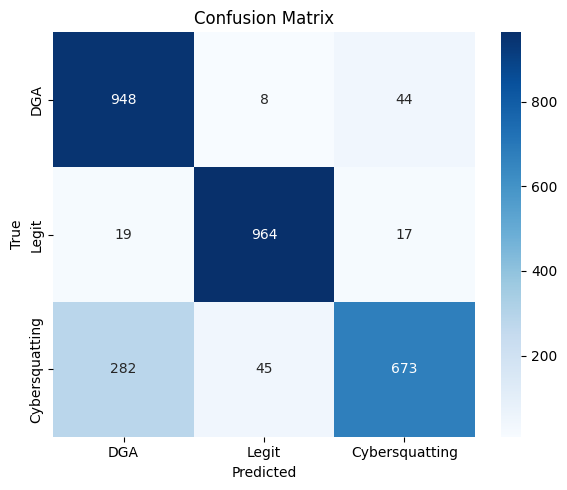

In [7]:
#Evaluation Testset
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = trainer.predict(tokenized_ds["test"])
preds = np.argmax(predictions.predictions[0], axis=1)
labels = predictions.label_ids

print("Test Accuracy:", accuracy_score(labels, preds))
print("Weighted F1:", f1_score(labels, preds, average='weighted'))

print("\nClassification Report:")
print(classification_report(labels, preds, target_names=["DGA", "Legit", "Cybersquatting"]))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["DGA", "Legit", "Cybersquatting"],
            yticklabels=["DGA", "Legit", "Cybersquatting"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [8]:
import shutil
import os
from IPython.display import FileLink, display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Speicherorte
model_dir = "/content/peft_domain_classifier"
report_path = "/content/classification_report.txt"
conf_matrix_path = "/content/confusion_matrix.png"
zip_path = "/content/peft_domain_classifier.zip"

# Modell und Tokenizer speichern
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

# Klassifikationsbericht schreiben
acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='weighted')
recall = classification_report(labels, preds, output_dict=True)['weighted avg']['recall']

with open(report_path, "w") as f:
    f.write(f"Test Accuracy: {acc:.4f}\n")
    f.write(f"Test Weighted F1-Score: {f1:.4f}\n")
    f.write(f"Test Weighted Recall: {recall:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(labels, preds, target_names=["DGA", "Legit", "Cybersquatting"]))

# Konfusionsmatrix speichern
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["DGA", "Legit", "Cybersquatting"],
            yticklabels=["DGA", "Legit", "Cybersquatting"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(conf_matrix_path)
plt.close()

# Zippen des Modellordners
shutil.make_archive(model_dir, 'zip', model_dir)

# Download-Links anzeigen
display(FileLink(zip_path, result_html_prefix="Modell: "))
display(FileLink(report_path, result_html_prefix="Bericht: "))
display(FileLink(conf_matrix_path, result_html_prefix="Matrix: "))
!ls -lh /content/

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/content/peft_domain_classifier.zip

/content/classification_report.txt

/content/confusion_matrix.png

total 8.8M
-rw-r--r--  1 root root  500 Jun  4 15:03 classification_report.txt
-rw-r--r--  1 root root  24K Jun  4 15:03 confusion_matrix.png
-rw-r--r--  1 root root 860K Jun  4 11:58 dga_squatting_legit_data_balanced.csv
drwxr-xr-x  2 root root 4.0K Jun  4 15:03 peft_domain_classifier
-rw-r--r--  1 root root 7.9M Jun  4 15:03 peft_domain_classifier.zip
drwxr-xr-x 31 root root 4.0K Jun  4 15:02 results
drwxr-xr-x  1 root root 4.0K Jun  2 13:39 sample_data
